# Data Preprocessing

## Importing the libraries

In [82]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import warnings

warnings.filterwarnings('ignore')

## Load the dataset

In [83]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_origin = pd.read_csv('games-regression-dataset.csv', 
                        parse_dates=['Original Release Date' , 'Current Version Release Date'], 
                        date_parser=dateparse)

## Download the icons

In [84]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)




def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons'):
    os.makedirs('icons')

# Download the images if they don't exist
for i, row in tqdm(df_origin.iterrows(), total=df_origin.shape[0]):
    if not os.path.exists('icons/' + str(i) + '.png'):
        download_image(row['Icon URL'], 'icons/' + str(i) + '.png')
        
# Replace the URL with the icon filename which is the index of the row
df_origin['Icon URL'] = df_origin.apply(lambda row : f'icons/{row.name}.png', axis=1)

100%|██████████| 5214/5214 [00:00<00:00, 8532.94it/s]


In [85]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df_origin, test_size=0.2, random_state=42)
df_test.to_csv('df_test.csv', index=False)

# drop Primary Genre
df.drop(['Primary Genre', 'ID', 'URL'], axis=1, inplace=True)

## Justifications

### Primary Genre: it is mostly 'Game' (around 98% of the data has 'Game' as the primary genre). It is not useful for the model.
### ID: it is just an ID for the apple store database, not useful for the model.
### URL: it is the URL of the app in the apple store, not useful for the model.

## Data Exploration

### General information

In [86]:
df.head()

,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Genres,Original Release Date,Current Version Release Date,Average User Rating
2173,Digfender,NaN,icons/2173.png,348,0.0,"3.99, 1.99, 3.99, 7.99, 4.99, 1.99, 9.99, 5.99...","""Digfender is easily one of the best tower def...",Mugshot Games Pty Ltd,9+,EN,479550464,"Games, Strategy, Puzzle",2015-11-18,2017-01-30,5.0
927,TowerMadness Zero,Classic Defense Strategy,icons/927.png,95466,0.0,"1.99, 1.99, 1.99, 2.99, 1.99, 1.99, 1.99, 1.99...","""Addictive, time-sucking fun. There are plenty...",Limbic Software,9+,"EN, DE",58547200,"Games, Puzzle, Strategy",2009-10-25,2018-03-05,4.0
2499,Free Gems Guide Calculator for Clash Of Clans ...,NaN,icons/2499.png,822,0.0,NaN,Welcome to your new favorite Clash of Clans Ca...,Tu Anh Do,17+,EN,22884352,"Games, Utilities, Strategy, Casual",2014-11-21,2016-01-14,3.5
45,Memory Sequence - Brain Game,"Bounce, Bounce, Bounce",icons/45.png,14,0.0,"2.99, 2.99","""Bounce, Bounce, Bounce your way past each obs...",OSUAPP LTD,4+,EN,164545536,"Games, Strategy, Casual, Education",2017-12-21,2019-06-18,4.5
1741,NEO Scavenger,Post-apocalyptic survival RPG,icons/1741.png,147,0.0,9.99,Play the acclaimed PC survival RPG on your tab...,"Blue Bottle Games, LLC",17+,EN,117317632,"Games, Entertainment, Role Playing, Strategy",2017-07-26,2017-11-28,4.0


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4171 entries, 2173 to 860
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Name                          4171 non-null   object        
 1   Subtitle                      1144 non-null   object        
 2   Icon URL                      4171 non-null   object        
 3   User Rating Count             4171 non-null   int64         
 4   Price                         4171 non-null   float64       
 5   In-app Purchases              2563 non-null   object        
 6   Description                   4171 non-null   object        
 7   Developer                     4171 non-null   object        
 8   Age Rating                    4171 non-null   object        
 9   Languages                     4165 non-null   object        
 10  Size                          4171 non-null   int64         
 11  Genres                      

In [88]:
df.isnull().sum()

Name                               0
Subtitle                        3027
Icon URL                           0
User Rating Count                  0
Price                              0
In-app Purchases                1608
Description                        0
Developer                          0
Age Rating                         0
Languages                          6
Size                               0
Genres                             0
Original Release Date              0
Current Version Release Date       0
Average User Rating                0
dtype: int64

### Genres

In [89]:
def genres_analysis(_df):
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    genre_counts = _df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
    print(genre_counts)


### Developer

In [90]:
def dev_analysis(_df):

    print(_df['Developer'].value_counts())
    
    # print the number developers with more than 1 game
    print(len(_df['Developer'].value_counts()[_df['Developer'].value_counts() > 1]))

    print(_df['Developer'].unique().size)

### Dates

In [91]:
def date_analysis(_df):
    # Plot the distribution of the date columns

    fig, ax = plt.subplots(5, 2, figsize=(20, 20))

    # df = date_preprocessing(df)

    # game_age distribution
    sns.histplot(_df['game_age'], ax=ax[0, 0])
    sns.boxplot(_df['game_age'], ax=ax[0, 1], orient='h')

    # last_update distribution
    sns.histplot(_df['last_update'], ax=ax[1, 0])
    sns.boxplot(_df['last_update'], ax=ax[1, 1], orient='h')

    # Original Release Date distribution
    sns.histplot(_df['Original Release Date'], ax=ax[2, 0])
    sns.boxplot(_df['Original Release Date'], ax=ax[2, 1], orient='h')

    # Current Version Release Date distribution
    sns.histplot(_df['Current Version Release Date'], ax=ax[3, 0])
    sns.boxplot(_df['Current Version Release Date'], ax=ax[3, 1], orient='h')

    # maintaning_period distribution
    sns.histplot(_df['maintaning_period'], ax=ax[4, 0])
    sns.boxplot(_df['maintaning_period'], ax=ax[4, 1], orient='h')

    plt.show()

# Date outliers are legitimate data points that are worth keeping, they are not errors nor anomalies

### Languages

In [92]:
def lang_analysis(_df):
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    langs_counts = _df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
    print(langs_counts[1:30])


array([[<AxesSubplot: title={'center': 'User Rating Count'}>,
        <AxesSubplot: title={'center': 'Price'}>],
       [<AxesSubplot: title={'center': 'Size'}>,
        <AxesSubplot: title={'center': 'Original Release Date'}>],
       [<AxesSubplot: title={'center': 'Current Version Release Date'}>,
        <AxesSubplot: title={'center': 'Average User Rating'}>]],
      dtype=object)

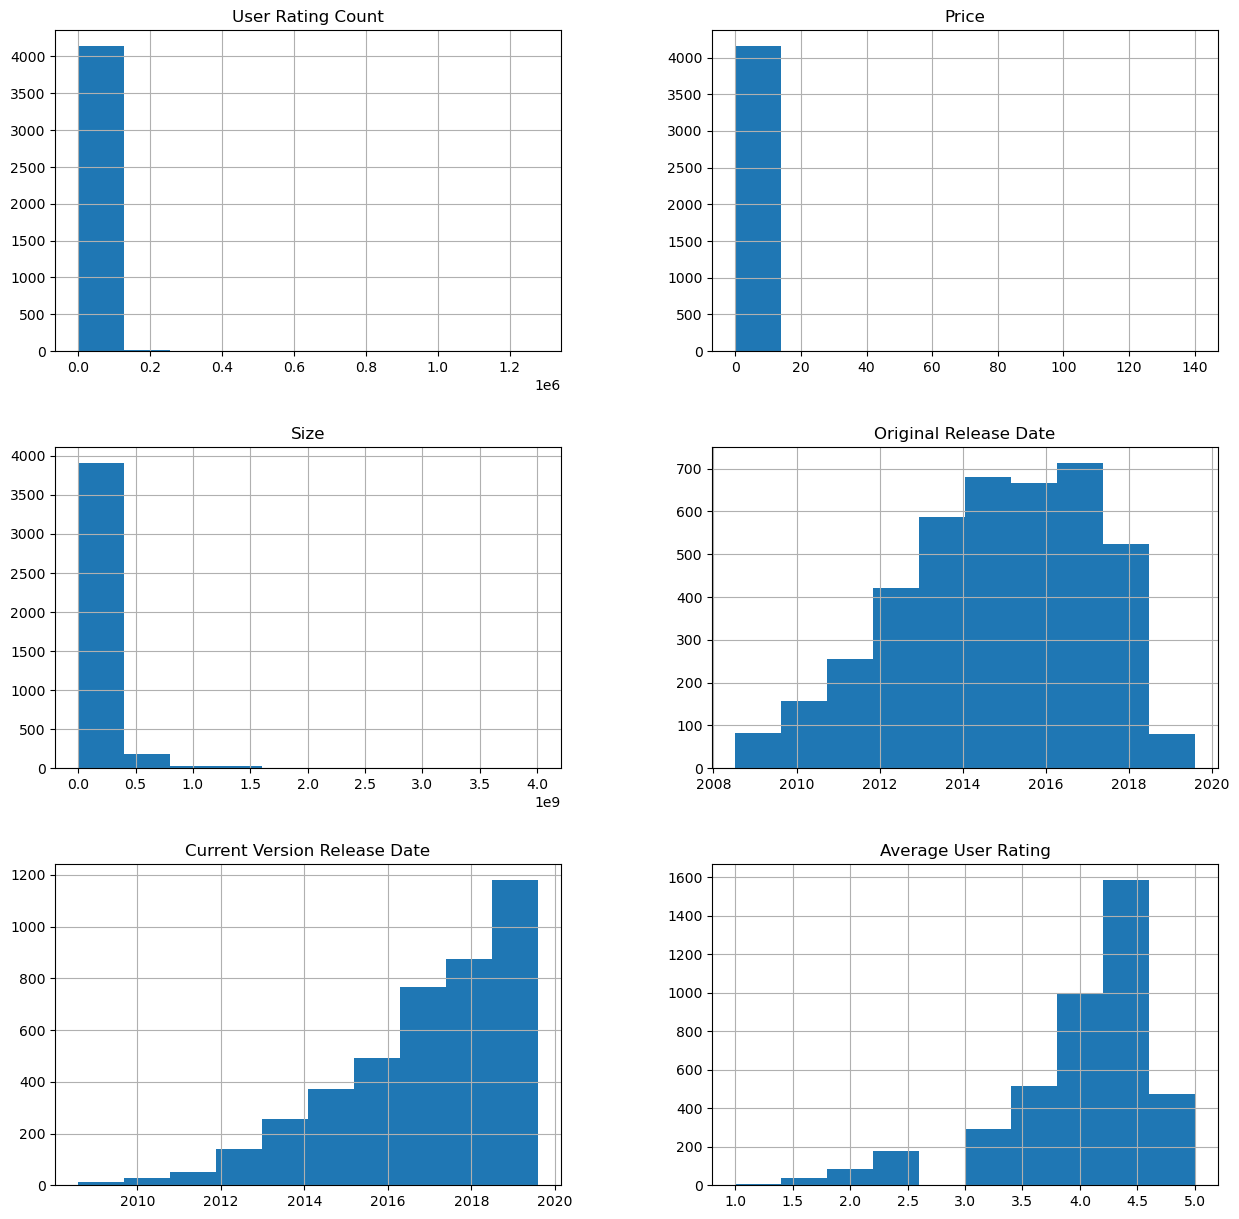

In [93]:
df.hist(figsize=(15, 15))

## Dates preprocessing

In [94]:
def date_preprocess(_df):
    # Convert the datetime to ordinal
    _df['Original Release Date'] = _df['Original Release Date'].apply(lambda x: x.toordinal())
    _df['Current Version Release Date'] = _df['Current Version Release Date'].apply(lambda x: x.toordinal())
    
    # Create a new column with the age of the game
    _df['game_age'] = datetime.now().toordinal() - _df['Original Release Date']

    # Create a new column with the time since the last update
    _df['last_update'] = datetime.now().toordinal() - _df['Current Version Release Date']
    
    # Create a new column with the maintaning period
    _df['maintaning_period'] = _df['last_update'] - _df['game_age']

    return _df

## Developer preprocessing

### Target encoding approach

In [95]:
def dev_preprocess_target_enc(_df):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')

    # Replace the developer names with less than 3 games with 'Other'
    dev_counts = _df['Developer'].value_counts()
    other = dev_counts[dev_counts < 2].index
    
    # Drop rows with developers in other
    # _df = _df[~_df['Developer'].isin(other)]
    
    _df['Developer'] = _df['Developer'].replace(other, 'Other')

    # Get the average user rating for all the developers that have more than 1 game
    mean = _df.groupby('Developer').filter(lambda x: len(x) > 1)['Average User Rating'].mean()
    
    dev_df = _df[['Developer', 'Average User Rating']].groupby('Developer').mean()
    
    # Replace 'Other' with the mean value
    dev_df['Other'] = mean

    # Save dev_df to be used on the test set
    dev_df.to_csv('encoders/dev_avg.csv')

    # Replace the developer names with the average user rating from dev_df
    _df['dev_avg'] = _df['Developer'].replace(dev_df.index, dev_df['Average User Rating'])
    
    return _df

### Frequency encoding approach

In [96]:
# Frequency encoding

def dev_preprocess_freq_enc(_df):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    # Get the frequency of each developer
    dev_freqs = _df['Developer'].value_counts()
    
    # Save dev_freqs to be used on the test set
    dev_freqs.to_csv('encoders/dev_freq.csv')
    
    # Create a new column with the frequency of each developer
    _df['dev_freq'] = _df['Developer'].replace(dev_freqs.index, dev_freqs.values)
        
    return _df


## Genres preprocessing

### 1. NLP approach (Bag of Words)

In [97]:
def genres_preprocess_bow(_df):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

    # Join the list of genres into a single string
    genres = _df['Genres'].apply(lambda x: ' '.join(x))

    # Create a count Vectorizer and fit it to the genres
    count_vec = CountVectorizer()
    bow_genres = count_vec.fit_transform(genres)
    
    # Save the count vectorizer to be used on the test set
    pickle.dump(count_vec, open('encoders/count_vec.pkl', 'wb'))

    # Apply principal component analysis to reduce the dimensionality
    pca = PCA(n_components=10)
    pca_genres = pca.fit_transform(bow_genres.toarray())

    # Add the PCA-transformed genres to the original dataframe
    for i in range(10):
        _df[f'genre_{i}'] = pca_genres[:, i]

    return _df

### 2. Dummy variables approach

In [98]:
def genres_preprocessing_dummies(_df):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])
    
    # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
    threshold = _df.shape[0] * 0.02
    
    other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])
    
    # Get dummy variables for the genres
    genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
    
    # Save the genres dummies to be used on the test set
    genres.to_csv('encoders/genres.csv', index=False)
    
    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, genres], axis=1)
    
    # Fill the NaN values with 0
    genre_cols = [col for col in _df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
    _df[genre_cols] = _df[genre_cols].fillna(0) # fill the NaN values with 0
    
    return _df

### 3. Multi-label binarizer

In [99]:
def genres_preprocessing_mlb(_df):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

    # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
    threshold = _df.shape[0] * 0.02

    other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent_genre' for genre in x])

    # Instantiate the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit the MultiLabelBinarizer to the genres
    mlb.fit(_df['Genres'])

    # Drop nan from the classes
    mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

    # Save the mlb for later use with the test data
    pickle.dump(mlb, open('encoders/mlb_genres.pkl', 'wb'))

    # Transform the genres into a one-hot encoded array
    genres_mlb = mlb.transform(_df['Genres'])

    # Create a dataframe from the one-hot encoded array
    genres_mlb_df = pd.DataFrame(genres_mlb, columns=mlb.classes_)

    # Add the one-hot encoded genres to the original dataframe
    _df = pd.concat([_df, genres_mlb_df], axis=1)
    
    return _df

## Languages preprocessing

### 1. NLP approach

In [100]:
def lang_preprocessing_bow(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    # Join the list of langs into a single string
    languages = _df['Languages'].apply(lambda x: ' '.join(x))
    
    # Create a count Vectorizer and fit it to the langs
    count_vec = CountVectorizer()
    bow_languages = count_vec.fit_transform(languages)
    
    # Save the count vectorizer to be used on the test set
    pickle.dump(count_vec, open('encoders/count_vec_lang.pkl', 'wb'))
    
    # Apply principal component analysis to reduce the dimensionality
    pca = PCA(n_components=10)
    pca_languages = pca.fit_transform(bow_languages.toarray())
    
    # Save the pca to be used on the test set
    pickle.dump(pca, open('encoders/pca_lang.pkl', 'wb'))
    
    # Add the PCA-transformed langs to the original dataframe
    for i in range(len(pca_languages[0])):
        _df[f'lang_{i}'] = pca_languages[:, i]
        
    return _df


### 2. Dummy variables approach

In [101]:
def lang_preprocess_dummies(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x)) 
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    # Replace languages with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 10%)
    threshold = _df.shape[0] * 0.1
    
    # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
    other = _df['Languages'].explode().value_counts()[_df['Languages'].explode().value_counts() < threshold].index
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

    # Get dummy variables for the langs
    langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

    langs.to_csv('encoders/langs.csv', index=False)

    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, langs], axis=1)

    # Fill NaN with 0
    lang_cols = [col for col in _df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
    _df[lang_cols] = _df[lang_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df
    
    

### 3. Multi-label binarizer

In [102]:
def lang_preprocess_mlb(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x))

    # Drop the English language from the Languages column (it is the most common language and would dominate the model)
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

    # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
    other = _df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 400].index
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent_lang' for lang in x])

    # Instantiate the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit the MultiLabelBinarizer to the langs
    mlb.fit(_df['Languages'])

    # Drop nan from the classes
    mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

    # Save the mlb for later use with the test data
    pickle.dump(mlb, open('encoders/mlb_langs.pkl', 'wb'))

    # Transform the langs into a one-hot encoded array
    langs_mlb = mlb.transform(_df['Languages'])

    # Create a dataframe from the one-hot encoded array
    langs_mlb_df = pd.DataFrame(langs_mlb, columns=mlb.classes_)

    # Add the encoded langs to the original dataframe
    _df = pd.concat([_df, langs_mlb_df], axis=1)
    
    return _df

## In-app Purchases preprocessing

In [103]:
# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

def purchases_preprocess(_df):
    # Convert the In-app Purchases column to a list of floats
    _df['In-app Purchases'] = _df['In-app Purchases'].astype(str)
    _df['In-app Purchases'] = _df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Convert to float
    _df['In-app Purchases'] = _df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

    # Get the number of in-app purchases
    _df['purchases_count'] = _df['In-app Purchases'].apply(lambda x: len(x))

    # Get the lowest, highest and average purchase
    _df['lowest_purchase'] = _df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
    _df['highest_purchase'] = _df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
    _df['average_purchase'] = _df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

    _df['lowest_purchase'] = _df['lowest_purchase'].fillna(0)
    _df['highest_purchase'] = _df['highest_purchase'].fillna(0)
    _df['average_purchase'] = _df['average_purchase'].fillna(0)
    
    return _df

## Age Rating preprocessing

In [104]:
def age_preprocess(_df):
    # Convert to string
    _df['Age Rating'] = _df['Age Rating'].astype(str)

    # Remove the + sign
    _df['Age Rating'] = _df['Age Rating'].str.replace('+', '')

    # Convert to int
    _df['Age Rating'] = _df['Age Rating'].astype(float)
    
    return _df

## NLP preprocessing

In [105]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
import re

def preprocess_nlp(_df, col):
    # Convert to string
    _df[col] = _df[col].astype(str)

    # Remove URLs and email addresses
    _df[col] = _df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    _df[col] = _df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    stop = stopwords.words('english')
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Stemming
    st = nltk.PorterStemmer()
    _df[col] = _df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    _df[col] = _df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(_df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    _df[col] = _df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    _df[col] = _df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = CountVectorizer()
    BoW = vectorizer.fit_transform(_df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = PCA(n_components=2)
    pca_col = pca_.fit_transform(BoW.toarray())
    
    # Save the vectorizer and pca for later use with the test data
    pickle.dump(vectorizer, open(f'encoders/vectorizer_{col}.pkl', 'wb'))
    pickle.dump(pca_, open(f'encoders/pca_{col}.pkl', 'wb'))

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        _df[f'{col}_PCA_{feat}'] = pca_col[:, feat]
        
    return _df



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Icon preprocessing

In [106]:
def preprocess_icon(img_path):
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))

    # Extract color features using color histograms
    colors = ('b', 'g', 'r')
    color_features = []
    for k, col in enumerate(colors):
        hist = cv2.calcHist([img], [k], None, [256], [0, 256])
        color_features.append(hist)

    # Reshape the color features to have a single dimension
    color_features = np.concatenate(color_features).ravel()

    # Extract shape features using edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_features = np.array(edges).flatten()

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [107]:
def icons_preprocess(_df):

    # Create a list to store the feature vectors
    icon_features = []

    _df['Icon URL'] = _df['Icon URL'].astype(str)

    # Iterate over the images and extract the features
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        feature_vec = preprocess_icon(row['Icon URL'])
        icon_features.append((row['Icon URL'], feature_vec))
        
    # Apply PCA to reduce the number of features
    pca = PCA(n_components=4)
    pca.fit([f[1] for f in icon_features])
    reduced_features = pca.transform([f[1] for f in icon_features])

    # Save the pca instance for later use
    pickle.dump(pca, open('encoders/icon_pca.pkl', 'wb'))

    # Convert the reduced features to a dataframe
    icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                        'Icon1': reduced_features[:,0],
                                        'Icon2': reduced_features[:,1],
                                        'Icon3': reduced_features[:,2],
                                        'Icon4': reduced_features[:,3]})
    
    # Merge the icon features with the original dataframe on the icon URL
    _df = _df.merge(icon_features_df, on='Icon URL', how='left')
    
    return _df

## Pipeline

In [108]:
df = date_preprocess(df)

df = dev_preprocess_freq_enc(df)

df = dev_preprocess_target_enc(df)

df = genres_preprocessing_dummies(df)

df = lang_preprocess_dummies(df)

df = purchases_preprocess(df)

df = age_preprocess(df)

df = preprocess_nlp(df, 'Description')
df = preprocess_nlp(df, 'Subtitle')
df = preprocess_nlp(df, 'Name')
df = icons_preprocess(df)

df = df.drop(['Developer',
              'Genres',
              'Languages' ,
              'In-app Purchases',
              'Description',
              'Subtitle',
              'Name', 
              'Icon URL'], axis=1)

# Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

(4171, 18)
(4171, 19)
(4171, 20)
(4171, 32)
(4171, 43)
(4171, 47)
(4171, 47)
                                                   Name  \
2173                                          Digfender   
927                                   TowerMadness Zero   
2499  Free Gems Guide Calculator for Clash Of Clans ...   
45                         Memory Sequence - Brain Game   
1741                                      NEO Scavenger   
...                                                 ...   
466                                Spider Solitaire* HD   
3092                                     Space Madness!   
3772                      Chess for Kids - Play & Learn   
5191                                  Jungle Games Free   
860                                     Space Adventure   

                           Subtitle        Icon URL  User Rating Count  Price  \
2173                            NaN  icons/2173.png                348   0.00   
927        Classic Defense Strategy   icons/927.png 

100%|██████████| 4171/4171 [00:21<00:00, 192.96it/s]


## Scaling and Model Training

In [109]:
df = pd.read_csv('preprocessed_data.csv')

In [110]:
def eliminate_outliers(_df):

    # Calculate Z-scores for each data point
    z_scores = np.abs(stats.zscore(_df))

    # Define a threshold to identify an outlier
    threshold = 3

    # Get a list of row numbers which are outliers
    outlier_rows = np.where(z_scores > threshold)[0]

    print(f'Number of outliers: {len(outlier_rows)}')

    # Replace the outliers with the mean
    mean_values = np.mean(_df[~((z_scores > threshold).any(axis=1))], axis=0)
    _df[~((z_scores > threshold).any(axis=1))] = _df[~((z_scores > threshold).any(axis=1))].fillna(mean_values)
    
    return _df

In [111]:
df_x = df.drop(['Average User Rating'], axis=1)
df_y = df['Average User Rating']

### Feature Scaling

In [112]:
# Scale the features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_data_std(_df):
    cols = _df.columns
    scaler = StandardScaler()
    _df = scaler.fit_transform(_df)
    
    # Save the scaler
    pickle.dump(scaler, open('scalers/std_scaler.pkl', 'wb'))
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df

def scale_data_minmax(_df):
    cols = _df.columns
    scaler = MinMaxScaler()
    _df = scaler.fit_transform(_df)
    
    # Save the scaler
    pickle.dump(scaler, open('scalers/minmax_scaler.pkl', 'wb'))
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df


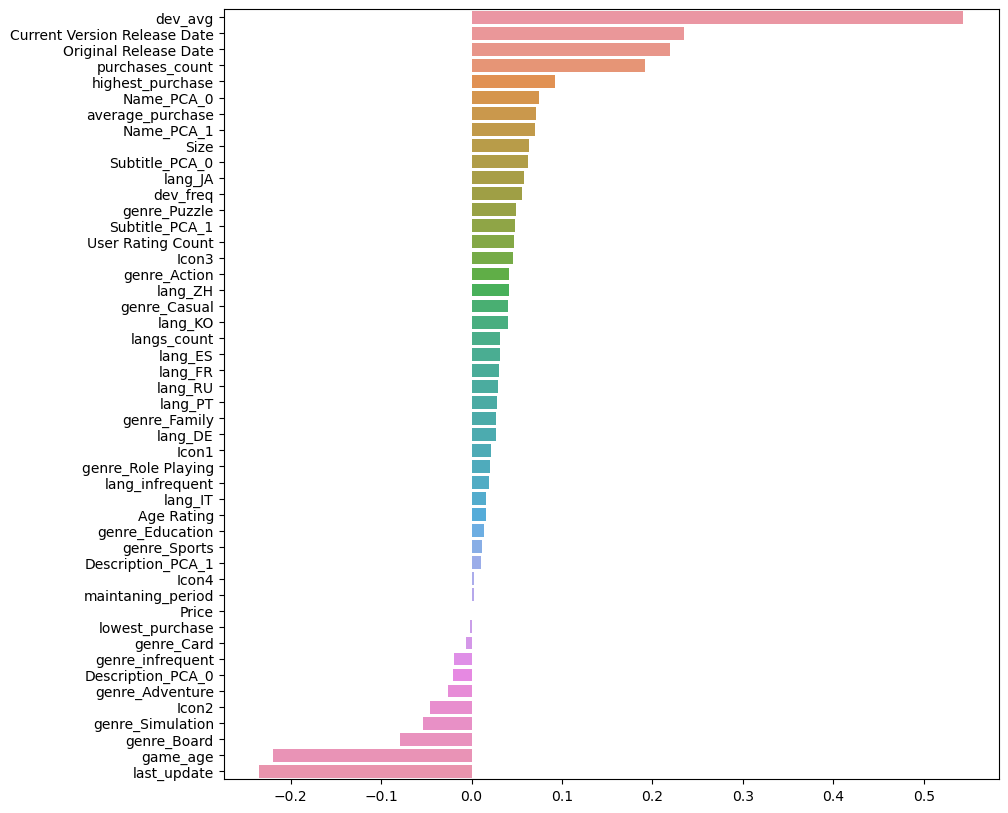

In [113]:
# plot correlation matrix between features and target
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

### Feature Selection

In [114]:
df_x = scale_data_std(df_x)

# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=10)
df_x_select =  selector.fit_transform(df_x, df_y)

# Save the selector
pickle.dump(selector, open('encoders/selector.pkl', 'wb'))

In [115]:
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

Original Release Date
Current Version Release Date
game_age
last_update
dev_avg
genre_Board
purchases_count
highest_purchase
average_purchase
Name_PCA_0


### Linear Regression

In [116]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


In [117]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/LR_model.pkl', 'wb'))



Training MSE:  0.37811881728541447
Training R2:  0.3282755378501925


### Ridge Regression

In [118]:
# Create a ridge regression model
model = Ridge(alpha=20)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/Ridge_model.pkl', 'wb'))


Training MSE:  0.37812395974611146
Training R2:  0.32826640231795257


### Lasso Regression

In [119]:
# Create a lasso regression model
model = Lasso(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/Lasso_model.pkl', 'wb'))


Training MSE:  0.3781644688684066
Training R2:  0.32819443824967054


### Elastic Net Regression

In [120]:
# Create an elastic net regression model
model = ElasticNet(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/ElasticNet_model.pkl', 'wb'))


Training MSE:  0.37813106379494965
Training R2:  0.3282537820431427


### Polynomial Regression

In [121]:
# Create a polynomial regression model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(df_x_select)

# Save the polynomial features
pickle.dump(poly, open('encoders/poly.pkl', 'wb'))

# Train the model
model = LinearRegression()
model.fit(X_train_poly, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(X_train_poly)))
print('Training R2: ', r2_score(df_y, model.predict(X_train_poly)))

# Save the model
pickle.dump(model, open('models/Polynomial_model.pkl', 'wb'))


Training MSE:  0.3696336729900371
Training R2:  0.3433493155293753


### XGBoost

In [122]:
# Create an XGBoost model

import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=3)
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/XGBoost_model.pkl', 'wb'))

Training MSE:  0.33885129906062916
Training R2:  0.39803390837739017


### Gradient Boosting

In [123]:
# Create a Gradient Boosting model

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.11)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/GradientBoosting_model.pkl', 'wb'))

Training MSE:  0.32484914969611633
Training R2:  0.4229085927909908


### Random Forest Regression

In [124]:
# Create a Random Forest Regressor model

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/RandomForest_model.pkl', 'wb'))

Training MSE:  0.3498858560504584
Training R2:  0.3784311234319915


## Done